In [ ]:
#| include: false
from nbdev.showdoc import *

Neural Network Pruning usually follows one of the next 3 schedules:

![](imgs/schedules.png "Schedules")

In fasterai, all those 3 schedules can be applied from the **same** callback. We'll cover each below

In the SparsifyCallback, there are several parameters to 'shape' our pruning schedule:
* `start_sparsity`: the initial sparsity of our model, generally kept at 0 as after initialization, our weights are generally non-zero.
* `end_sparsity`: the target sparsity at the end of the training 
* `start_epoch`: we can decide to start pruning right from the beginning or let it train a bit before removing weights.
* `sched_func`: this is where the general shape of the schedule is specified as it specifies how the sparsity evolves along the training. You can either use a schedule [available](https://docs.fast.ai/callback.schedule.html#Annealing) in fastai our even coming with your own !

---

In [ ]:
#| include: false
from fastai.vision.all import *
from fastai.callback.all import *

from fasterai.sparse.all import *

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns

sns.set(context='poster', style='white',
        font='sans-serif', font_scale=1, color_codes=True, rc=None)

/Users/nathan/opt/miniconda3/envs/nbdev/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
path = untar_data(URLs.PETS)

files = get_image_files(path/"images")

def label_func(f): return f[0].isupper()

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(64), device=device)

We will first train a network without any pruning, which will serve as a baseline.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

learn.fit_one_cycle(6)

/home/HubensN/miniconda3/envs/deep/lib/python3.8/site-packages/fastai/vision/learner.py:265: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time
0,0.703338,0.584460,0.833559,00:08
1,0.409266,0.277945,0.886333,00:07
2,0.272164,0.230810,0.900541,00:07
3,0.171919,0.202396,0.920162,00:07
4,0.095116,0.168309,0.937754,00:07
5,0.055808,0.167708,0.939107,00:07


## One-Shot Pruning

The simplest way to perform pruning is called One-Shot Pruning. It consists of the following three steps:

1. You first need to train a network
2. You then need to remove some weights (depending on your criteria, needs,...)
3. You fine-tune the remaining weights to recover from the loss of parameters.

With fasterai, this is really easy to do. Let's illustrate it by an example:

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In this case, your network needs to be trained before pruning. This training can be done independently from the pruning callback, or simulated by the `start_epoch` that will delay the pruning process.

You thus only need to create the Callback with the `one_shot` schedule and set the `start_epoch` argument, i.e. how many epochs you want to train your network before pruning it.

In [ ]:
sp_cb=SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=one_shot)

Let's start pruningn after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit_one_cycle(6, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.671942,0.521863,0.809878,00:07
1,0.433165,0.335386,0.868742,00:07
2,0.252873,0.223187,0.906631,00:07
3,0.151653,0.195924,0.922869,00:07
4,0.091317,0.169764,0.929635,00:07
5,0.055428,0.161210,0.934371,00:07


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [0.0]%
Sparsity at the end of epoch 2: [50.0]%
Sparsity at the end of epoch 3: [50.0]%
Sparsity at the end of epoch 4: [50.0]%
Sparsity at the end of epoch 5: [50.0]%
Final Sparsity: [50]%
Sparsity in Conv2d 2: 50.00%
Sparsity in Conv2d 8: 50.00%
Sparsity in Conv2d 11: 50.00%
Sparsity in Conv2d 14: 50.00%
Sparsity in Conv2d 17: 50.00%
Sparsity in Conv2d 21: 50.00%
Sparsity in Conv2d 24: 50.00%
Sparsity in Conv2d 27: 50.00%
Sparsity in Conv2d 30: 50.00%
Sparsity in Conv2d 33: 50.00%
Sparsity in Conv2d 37: 50.00%
Sparsity in Conv2d 40: 50.00%
Sparsity in Conv2d 43: 50.00%
Sparsity in Conv2d 46: 50.00%
Sparsity in Conv2d 49: 50.00%
Sparsity in Conv2d 53: 50.00%
Sparsity in Conv2d 56: 50.00%
Sparsity in Conv2d 59: 50.00%
Sparsity in Conv2d 62: 50.00%
Sparsity in Conv2d 65: 50.00%


---

## Iterative Pruning

Researchers have come up with a better way to do pruning than pruning all the weigths in once (as in One-Shot Pruning). The idea is to perform several iterations of pruning and fine-tuning and is thus called Iterative Pruning.

1. You first need to train a network
2. You then need to remove a part of the weights weights (depending on your criteria, needs,...)
3. You fine-tune the remaining weights to recover from the loss of parameters.
4. Back to step 2.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In this case, your network needs to be trained before pruning.

You only need to create the Callback with the `iterative` schedule and set the `start_epoch` argument, i.e. how many epochs you want to train your network before pruning it.

The `iterative` schedules has a `n_steps`parameter, i.e. how many iterations of pruning/fine-tuning you want to perform. To modify its value, we can use the `partial` function like this:

```
iterative = partial(iterative, n_steps=5)
```

In [ ]:
sp_cb=SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=iterative)

Let's start pruningn after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit_one_cycle(6, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.747520,0.534082,0.823410,00:07
1,0.406695,0.292009,0.876184,00:07
2,0.248393,0.211495,0.912720,00:07
3,0.138455,0.226409,0.912720,00:07
4,0.092650,0.205549,0.926928,00:07
5,0.056216,0.195934,0.931664,00:07


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [16.67]%
Sparsity at the end of epoch 2: [33.33]%
Sparsity at the end of epoch 3: [33.33]%
Sparsity at the end of epoch 4: [50.0]%
Sparsity at the end of epoch 5: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 2: 50.00%
Sparsity in Conv2d 8: 50.00%
Sparsity in Conv2d 11: 50.00%
Sparsity in Conv2d 14: 50.00%
Sparsity in Conv2d 17: 50.00%
Sparsity in Conv2d 21: 50.00%
Sparsity in Conv2d 24: 50.00%
Sparsity in Conv2d 27: 50.00%
Sparsity in Conv2d 30: 50.00%
Sparsity in Conv2d 33: 50.00%
Sparsity in Conv2d 37: 50.00%
Sparsity in Conv2d 40: 50.00%
Sparsity in Conv2d 43: 50.00%
Sparsity in Conv2d 46: 50.00%
Sparsity in Conv2d 49: 50.00%
Sparsity in Conv2d 53: 50.00%
Sparsity in Conv2d 56: 50.00%
Sparsity in Conv2d 59: 50.00%
Sparsity in Conv2d 62: 50.00%
Sparsity in Conv2d 65: 50.00%


---

## Gradual Pruning

Here is for example how to implement the [Automated Gradual Pruning](https://arxiv.org/pdf/1710.01878.pdf) schedule.

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy)
learn.unfreeze()

In [ ]:
sp_cb=SparsifyCallback(sparsity=50, granularity='weight', context='local', criteria=large_final, schedule=agp)

Let's start pruning after 3 epochs and train our model for 6 epochs to have the same total amount of training as before

In [ ]:
learn.fit_one_cycle(6, cbs=sp_cb)

Pruning of weight until a sparsity of [50]%
Saving Weights at epoch 0


epoch,train_loss,valid_loss,accuracy,time
0,0.675533,0.671494,0.815291,00:07
1,0.414929,0.261510,0.888363,00:07
2,0.261279,0.247027,0.903924,00:07
3,0.151988,0.198519,0.914750,00:07
4,0.088916,0.157761,0.933694,00:07
5,0.043516,0.148362,0.940460,00:07


Sparsity at the end of epoch 0: [0.0]%
Sparsity at the end of epoch 1: [21.02]%
Sparsity at the end of epoch 2: [37.79]%
Sparsity at the end of epoch 3: [46.39]%
Sparsity at the end of epoch 4: [49.55]%
Sparsity at the end of epoch 5: [50.0]%
Final Sparsity: [50.0]%
Sparsity in Conv2d 2: 50.00%
Sparsity in Conv2d 8: 50.00%
Sparsity in Conv2d 11: 50.00%
Sparsity in Conv2d 14: 50.00%
Sparsity in Conv2d 17: 50.00%
Sparsity in Conv2d 21: 50.00%
Sparsity in Conv2d 24: 50.00%
Sparsity in Conv2d 27: 50.00%
Sparsity in Conv2d 30: 50.00%
Sparsity in Conv2d 33: 50.00%
Sparsity in Conv2d 37: 50.00%
Sparsity in Conv2d 40: 50.00%
Sparsity in Conv2d 43: 50.00%
Sparsity in Conv2d 46: 50.00%
Sparsity in Conv2d 49: 50.00%
Sparsity in Conv2d 53: 50.00%
Sparsity in Conv2d 56: 50.00%
Sparsity in Conv2d 59: 50.00%
Sparsity in Conv2d 62: 50.00%
Sparsity in Conv2d 65: 50.00%


Even though they are often considered as different pruning methods, those 3 schedules can be captured by the same Callback. Here is how the sparsity in the network evolves for those methods;

Let's take an example here. Let's say that we want to train our network for 3 epochs without pruning and then 7 epochs with pruning.

In [ ]:
#| include: false
train = np.zeros(300)
prune = np.linspace(0,1, 700) 

In [ ]:
#| include: false
os = [sched_oneshot(0,50, p) for p in prune]

Then this is what our different pruning schedules will look like:

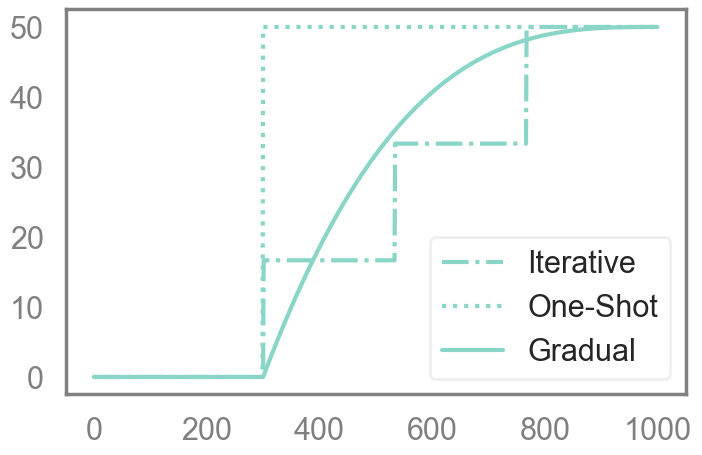

In [ ]:
#| echo: false
fig, ax = plt.subplots(1, 1, figsize=(8,5), dpi=100)
fig.patch.set_alpha(0.)
ax.patch.set_alpha(0.)
plt.plot(np.concatenate([train, sched_iterative(0,50, prune)]), label='Iterative', linestyle='-.', c='#89d6c9')
plt.plot(np.concatenate([train, os]), label='One-Shot', linestyle=':', c='#89d6c9')
plt.plot(np.concatenate([train, sched_agp(0,50, prune)]), label='Gradual', c='#89d6c9')
ax.spines['bottom'].set_color('#808080')
ax.spines['top'].set_color('#808080') 
ax.spines['right'].set_color('#808080')
ax.spines['left'].set_color('#808080')
ax.tick_params(axis='x', colors='#808080')
ax.tick_params(axis='y', colors='#808080')
ax.yaxis.label.set_color('#808080')
ax.xaxis.label.set_color('#808080')
plt.legend(framealpha=0.3);

**You can also come up with your own pruning schedule !**